In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import pysal as ps
import seaborn as sns
import geopandas as gpd
import plotly.express as px

import geopandas as gpd
from shapely.geometry import Point
from pyproj import Transformer

import os
import pandas as pd

from sklearn.decomposition import PCA


import warnings
warnings.filterwarnings("ignore")

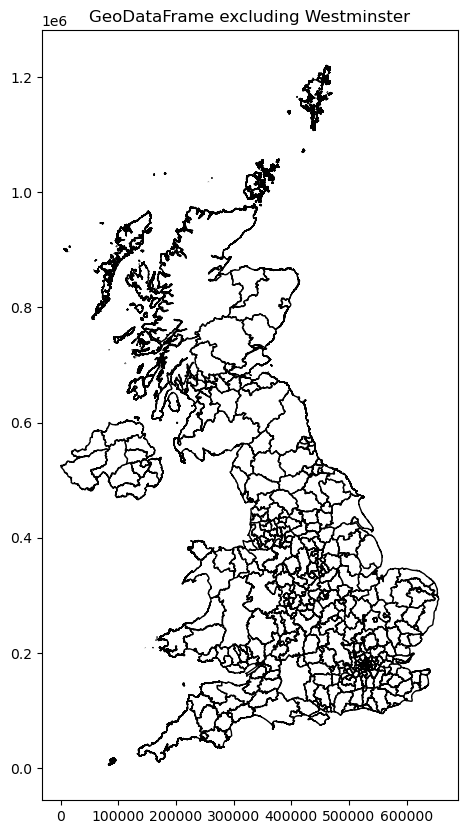

In [2]:
temp_msoa = gpd.read_file("data_collection/LAD_May_2020_Boundaries_UK_BFE_2022_-5822860364470735119/Local_Authority_Districts__May_2020__Boundaries_UK_BFE.shp")
# Plot the filtered GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 10))
temp_msoa.plot(ax=ax, color='white', edgecolor='black')

# Customize the plot
ax.set_title('GeoDataFrame excluding Westminster')
plt.show()


In [3]:
temp_msoa

objectid_1    lad20cd               lad20nm        lad20nmw   bng_e  \
0             1  E06000001            Hartlepool             NaN  447160   
1             2  E06000002         Middlesbrough             NaN  451141   
2             3  E06000003  Redcar and Cleveland             NaN  464361   
3             4  E06000004      Stockton-on-Tees             NaN  444940   
4             5  E06000005            Darlington             NaN  428029   
..          ...        ...                   ...             ...     ...   
374         375  W06000020               Torfaen         Torfaen  327459   
375         376  W06000021         Monmouthshire       Sir Fynwy  337812   
376         377  W06000022               Newport       Casnewydd  337897   
377         378  W06000023                 Powys           Powys  302329   
378         379  W06000024        Merthyr Tydfil  Merthyr Tudful  305916   

      bng_n     long        lat    st_areasha     st_lengths  \
0    531474 -1.27018  54.676140  9.834667e+07   66121.472650   
1    516887 -1.21099  54.544670  5.455359e+07   41055.809886   
2    519597 -1.00608  54.567520  2.537854e+08  105292.138896   
3    518183 -1.30664  54.556911  2.097308e+08  108085.255484   
4    515648 -1.56835  54.535339  1.974757e+08  107206.401677   
..      ...      ...        ...           ...            ...   
374  200480 -3.05101  51.698360  1.262399e+08   82544.775967   
375  209231 -2.90280  51.778271  8.860000e+08  250892.734308   
376  187432 -2.89769  51.582310  2.175180e+08  135651.645859   
377  273255 -3.43531  52.348640  5.195456e+09  606560.369136   
378  206424 -3.36425  51.748581  1.119570e+08   66696.929592   

                                 GlobalID  \
0    ba12d24f-5401-4f2f-82df-91fa6d4e77e8   
1    470e251c-3916-47bf-9ce1-50af29a1f15c   
2    e2b2983a-dd19-444b-a2ee-0ec5ab8484fe   
3    66f236f8-d480-49f9-9b78-89c48bd2723f   
4    6fb2e38a-6088-4c5f-bed8-662a6396ad43   
..                                    ...   
374  5da02fec-1148-4aa7-a11e-6fd1ac334b6b   
375  b4d36cca-119c-49ba-985c-774263e397ae   
376  0875e9dc-ab2a-4692-bacf-790497759467   
377  cbd1c8f1-d3a2-4b19-ac9d-b9dee9578639   
378  7a528f96-e9c6-4144-a751-d69a0494d7a2   

                                              geometry  
0    POLYGON ((447213.900 537036.104, 447228.798 53...  
1    POLYGON ((448489.897 522071.798, 448592.597 52...  
2    POLYGON ((455525.931 528406.654, 455724.632 52...  
3    POLYGON ((444157.002 527956.304, 444165.898 52...  
4    POLYGON ((423496.602 524724.299, 423497.204 52...  
..                                                 ...  
374  POLYGON ((323898.201 211287.499, 324115.698 21...  
375  MULTIPOLYGON (((345806.401 180943.905, 345807....  
376  POLYGON ((342211.900 194845.495, 342221.803 19...  
377  POLYGON ((322392.901 334017.198, 322378.002 33...  
378  POLYGON ((303435.502 214925.598, 303431.602 21...  

[379 rows x 12 columns]

In [4]:
temp_msoa.rename(columns={'lad20cd': 'geo_code'}, inplace=True)


len(temp_msoa['geo_code'].unique().tolist())

379

In [5]:
collision = pd.read_csv('data_collection/2022/collision-2022.csv')

In [6]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Assuming collision is already loaded and contains 'location_easting_osgr' and 'location_northing_osgr'
# Assuming geo_df is your GeoDataFrame containing the 'geo_code' and 'geometry' columns


collision['lsoa_of_accident_location'] = -1
collision.rename(columns={'lsoa_of_accident_location': 'msoa_of_accident_location'}, inplace=True)


# Step 1: Convert the collision DataFrame to a GeoDataFrame
collision_gdf = gpd.GeoDataFrame(
    collision,
    geometry=gpd.points_from_xy(collision.location_easting_osgr, collision.location_northing_osgr),
    crs="EPSG:27700"  # Assuming the coordinate system is British National Grid
)

# Step 2: Perform a spatial join to match coordinates with polygons
joined_gdf = gpd.sjoin(collision_gdf, temp_msoa[['geo_code', 'geometry']], how="left", op="within")

# Merge the DataFrames on 'accident_index'
merged_df = collision.merge(joined_gdf[['accident_index', 'geo_code']], on='accident_index', how='left')

# Replace 'msoa_of_accident_location' with 'geo_code' where applicable
collision['msoa_of_accident_location'] = merged_df['geo_code']


In [7]:
# Count the number of occurrences of '-1' in the 'msoa_of_accident_location' column
num_negative_ones = (collision['msoa_of_accident_location'] == '-1').sum()

print(f"The number of occurrences of '-1' in 'msoa_of_accident_location': {num_negative_ones}")


The number of occurrences of '-1' in 'msoa_of_accident_location': 0


In [8]:
len(collision['msoa_of_accident_location'].unique().tolist())

369

In [9]:
collision.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106004 entries, 0 to 106003
Data columns (total 36 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   accident_index                               106004 non-null  object 
 1   accident_year                                106004 non-null  int64  
 2   accident_reference                           106004 non-null  object 
 3   location_easting_osgr                        105982 non-null  float64
 4   location_northing_osgr                       105982 non-null  float64
 5   longitude                                    105982 non-null  float64
 6   latitude                                     105982 non-null  float64
 7   police_force                                 106004 non-null  int64  
 8   accident_severity                            106004 non-null  int64  
 9   number_of_vehicles                           106004 non-nul

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.parser import parse

# Function to parse dates with mixed formats
def parse_dates(date_str):
    try:
        return parse(date_str, dayfirst=True)
    except ValueError:
        return pd.NaT

# Drop rows with invalid dates
collision = collision.dropna(subset=['date'])

# Create a DataFrame for the holidays
holiday_data = {
    'Date': [
        '3 January 2022', '17 March 2022', '15 April 2022', '18 April 2022', '2 May 2022',
        '2 June 2022', '3 June 2022', '12 July 2022', '29 August 2022', '26 December 2022', '27 December 2022'
    ],
    'Day': [
        'Monday', 'Thursday', 'Friday', 'Monday', 'Monday',
        'Thursday', 'Friday', 'Tuesday', 'Monday', 'Monday', 'Tuesday'
    ],
    'Reason': [
        'New Year’s Day (Substitute Day)', 'St Patrick’s Day', 'Good Friday', 'Easter Monday', 'Early May Bank Holiday',
        'Spring Bank Holiday', 'Platinum Jubilee Bank Holiday', 'Battle of the Boyne (Orangemen’s Day)', 'Summer Bank Holiday', 'Boxing Day', 'Christmas Day (Substitute Day)'
    ]
}

holidays = pd.DataFrame(holiday_data)
holidays['Date'] = pd.to_datetime(holidays['Date'], format='%d %B %Y')

collision['date'] = pd.to_datetime(collision['date'], format='%d/%m/%Y')

# Function to determine if a date is a weekend or holiday
def is_weekend_or_holiday(date):
    return date in holiday_dates or date.weekday() >= 5  # 5 and 6 correspond to Saturday and Sunday

# Create a set of holiday dates
holiday_dates = set(holidays['Date'])

# Apply the function to create a new column
collision['is_weekend_or_holiday'] = collision['date'].apply(is_weekend_or_holiday)

# Separate the data
weekends_holidays = collision[collision['is_weekend_or_holiday']]
working_days = collision[~collision['is_weekend_or_holiday']]

In [11]:
collision

accident_index  accident_year accident_reference  \
0       2022010352073           2022           10352073   
1       2022010352573           2022           10352573   
2       2022010352575           2022           10352575   
3       2022010352578           2022           10352578   
4       2022010352580           2022           10352580   
...               ...            ...                ...   
105999  2022991311627           2022          991311627   
106000  2022991312498           2022          991312498   
106001  2022991315177           2022          991315177   
106002  2022991321308           2022          991321308   
106003  2022991322411           2022          991322411   

        location_easting_osgr  location_northing_osgr  longitude   latitude  \
0                    525199.0                177928.0  -0.198224  51.486454   
1                    546214.0                179866.0   0.105042  51.498830   
2                    551119.0                174789.0   0.173482  51.451924   
3                    528889.0                192230.0  -0.139873  51.614153   
4                    539773.0                190404.0   0.016495  51.595151   
...                       ...                     ...        ...        ...   
105999               235016.0                625551.0  -4.613246  55.495815   
106000               127459.0                663067.0  -6.348650  55.783849   
106001               254396.0                663549.0  -4.326930  55.843114   
106002               325409.0                677054.0  -3.196963  55.980648   
106003               324745.0                673696.0  -3.206662  55.950381   

        police_force  accident_severity  number_of_vehicles  ...  \
0                  1                  3                   2  ...   
1                  1                  3                   2  ...   
2                  1                  3                   2  ...   
3                  1                  3                   2  ...   
4                  1                  3                   4  ...   
...              ...                ...                 ...  ...   
105999            99                  2                   1  ...   
106000            99                  2                   3  ...   
106001            99                  3                   1  ...   
106002            99                  2                   1  ...   
106003            99                  2                   1  ...   

        light_conditions weather_conditions  road_surface_conditions  \
0                      4                  1                        1   
1                      4                  1                        1   
2                      4                  1                        1   
3                      4                  1                        1   
4                      4                  1                        1   
...                  ...                ...                      ...   
105999                 1                  1                        1   
106000                 6                  1                        1   
106001                 1                  1                        1   
106002                 4                  1                        1   
106003                 4                  1                        2   

       special_conditions_at_site  carriageway_hazards urban_or_rural_area  \
0                               0                    0                   1   
1                               0                    0                   2   
2                               0                    0                   1   
3                               0                    0                   1   
4                               0                    0                   1   
...                           ...                  ...                 ...   
105999                          0                    0                   1   
106000                          0          

In [12]:
import pandas as pd

# Sample collision data for illustration
# collision = pd.read_csv('path_to_collision_data.csv')

# Step 1: Convert the 'time' column to datetime format if it is not already
collision['time'] = pd.to_datetime(collision['time'], format='%H:%M').dt.time

# Step 2: Create a new column 'time_range' with times rounded to the nearest 30-minute interval
collision['time_range'] = pd.to_datetime(collision['time'].astype(str)).dt.floor('30T').dt.time

# Print the updated collision DataFrame to verify the changes
print(collision.head())


  accident_index  accident_year accident_reference  location_easting_osgr  \
0  2022010352073           2022           10352073               525199.0   
1  2022010352573           2022           10352573               546214.0   
2  2022010352575           2022           10352575               551119.0   
3  2022010352578           2022           10352578               528889.0   
4  2022010352580           2022           10352580               539773.0   

   location_northing_osgr  longitude   latitude  police_force  \
0                177928.0  -0.198224  51.486454             1   
1                179866.0   0.105042  51.498830             1   
2                174789.0   0.173482  51.451924             1   
3                192230.0  -0.139873  51.614153             1   
4                190404.0   0.016495  51.595151             1   

   accident_severity  number_of_vehicles  ...  weather_conditions  \
0                  3                   2  ...                   1   
1       

In [13]:
# Step 1: Create a date range from 00:00 to 24:00 with 30-minute intervals
time_range = pd.date_range(start="00:00", end="23:59", freq="30T").time

# Step 2: Extract unique local authority codes from the 'local_authority_highway' column
local_authority_codes = collision['msoa_of_accident_location'].unique()

# Step 3: Create empty DataFrames for working days, non-working days, and all days
working_days_avg = pd.DataFrame(index=time_range, columns=local_authority_codes).fillna(0)
weekends_holidays_avg = pd.DataFrame(index=time_range, columns=local_authority_codes).fillna(0)
combined_avg = pd.DataFrame(index=time_range, columns=local_authority_codes).fillna(0)

# Step 4: Separate the data into working days and weekends/holidays
working_days = collision[~collision['is_weekend_or_holiday']]
weekends_holidays = collision[collision['is_weekend_or_holiday']]

In [14]:
# Group by `time_interval` and `area_code` and count collisions
working_days_counts = working_days.groupby(['time_range', 'msoa_of_accident_location']).size().unstack(fill_value=0)

df = working_days.set_index('date')
total_days = len(working_days['date'].unique())
working_days_counts = working_days_counts/total_days

# Reindex the `collision_counts` DataFrame to ensure it has all the necessary time intervals
time_intervals = pd.date_range(start="00:00", end="23:30", freq="30T").time
working_days_counts = working_days_counts.reindex(index=time_intervals, columns=working_days_avg.columns, fill_value=0)

# Update `working_days_avg` with the counts
working_days_avg.update(working_days_counts)
working_days_avg.index = working_days_avg.index.map(lambda x: x.strftime('%H:%M'))


In [15]:
# Group by `time_interval` and `area_code` and count collisions
weekends_holidays_counts = weekends_holidays.groupby(['time_range', 'msoa_of_accident_location']).size().unstack(fill_value=0)

df = weekends_holidays.set_index('date')
total_days = len(weekends_holidays['date'].unique())
weekends_holidays_counts = weekends_holidays_counts/total_days
# Reindex the `collision_counts` DataFrame to ensure it has all the necessary time intervals
time_intervals = pd.date_range(start="00:00", end="23:30", freq="30T").time
weekends_holidays_counts = weekends_holidays_counts.reindex(index=time_intervals, columns=weekends_holidays_avg.columns, fill_value=0)

# Update `working_days_avg` with the counts
weekends_holidays_avg.update(weekends_holidays_counts)
weekends_holidays_avg.index = weekends_holidays_avg.index.map(lambda x: x.strftime('%H:%M'))


In [16]:
# Group by `time_interval` and `area_code` and count collisions
combined_counts = collision.groupby(['time_range', 'msoa_of_accident_location']).size().unstack(fill_value=0)

df = collision.set_index('date')
total_days = len(collision['date'].unique())
combined_counts = combined_counts/total_days

# Reindex the `collision_counts` DataFrame to ensure it has all the necessary time intervals
time_intervals = pd.date_range(start="00:00", end="23:30", freq="30T").time
combineds_counts = combined_counts.reindex(index=time_intervals, columns=combined_avg.columns, fill_value=0)

# Update `working_days_avg` with the counts
combined_avg.update(combined_counts)
combined_avg.index = combined_avg.index.map(lambda x: x.strftime('%H:%M'))


In [17]:
print(len(working_days['date'].unique()))
print(len(weekends_holidays['date'].unique()))

249
116


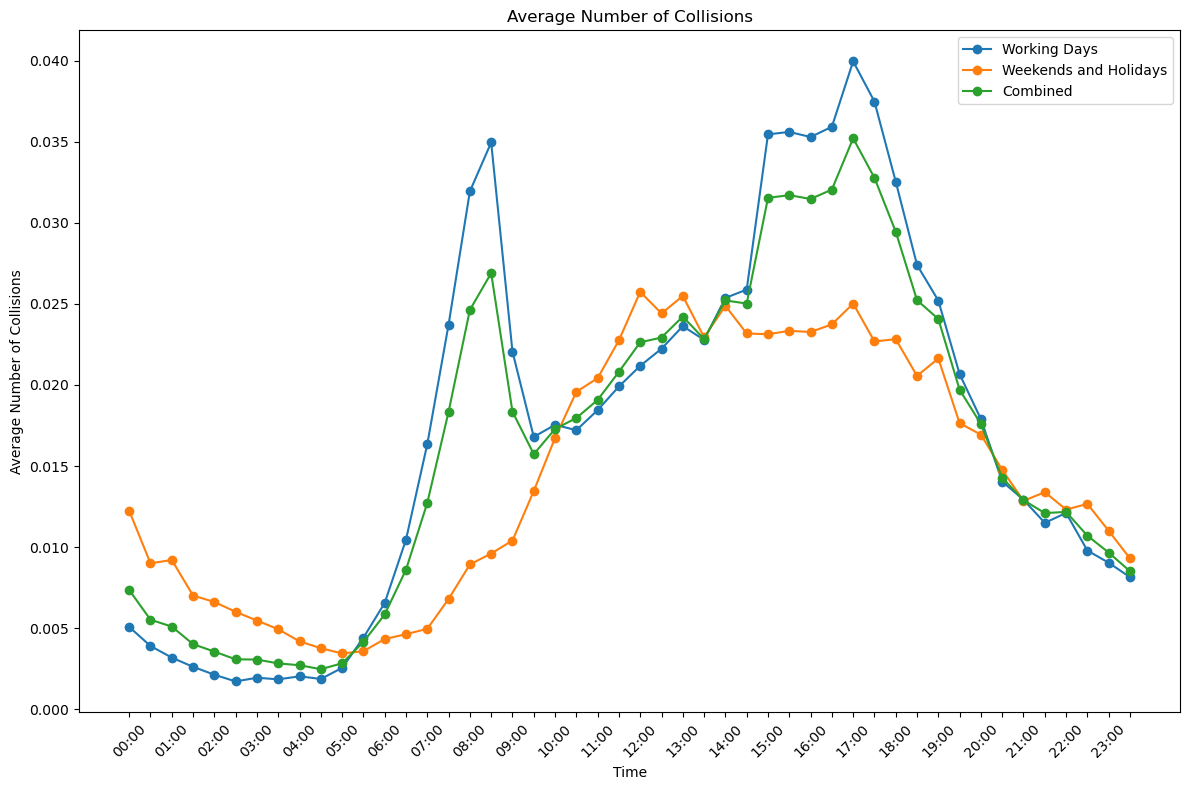

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `working_days_avg`, `weekends_holidays_avg`, and `combined_avg` DataFrames are already available

# Compute the average sum of all zones for each time interval
working_days_avg_sum = working_days_avg.mean(axis=1)
weekends_holidays_avg_sum = weekends_holidays_avg.mean(axis=1)
combined_avg_sum = combined_avg.mean(axis=1)

# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot for working days
ax.plot(working_days_avg_sum.index, working_days_avg_sum, marker='o', label='Working Days')

# Plot for weekends and holidays
ax.plot(weekends_holidays_avg_sum.index, weekends_holidays_avg_sum, marker='o', label='Weekends and Holidays')

# Plot combined
ax.plot(combined_avg_sum.index, combined_avg_sum, marker='o', label='Combined')

# Set titles and labels
ax.set_title('Average Number of Collisions')
ax.set_xlabel('Time')
ax.set_ylabel('Average Number of Collisions')

# Define a function to format the x-axis labels to show only the hour
def format_hour_only(x, pos):
    if x % 2 == 0:
        hour = int(x/2)
        return f'{hour:02d}:00'
    else:
        return ''

# Set the x-axis ticks to every half-hour (assuming numeric index with half-hour intervals)
ax.set_xticks(working_days_avg_sum.index)

# Set the formatter to use the format_hour_only function
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_hour_only))

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Add legend
ax.legend()

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('fig/total.png')
plt.show()


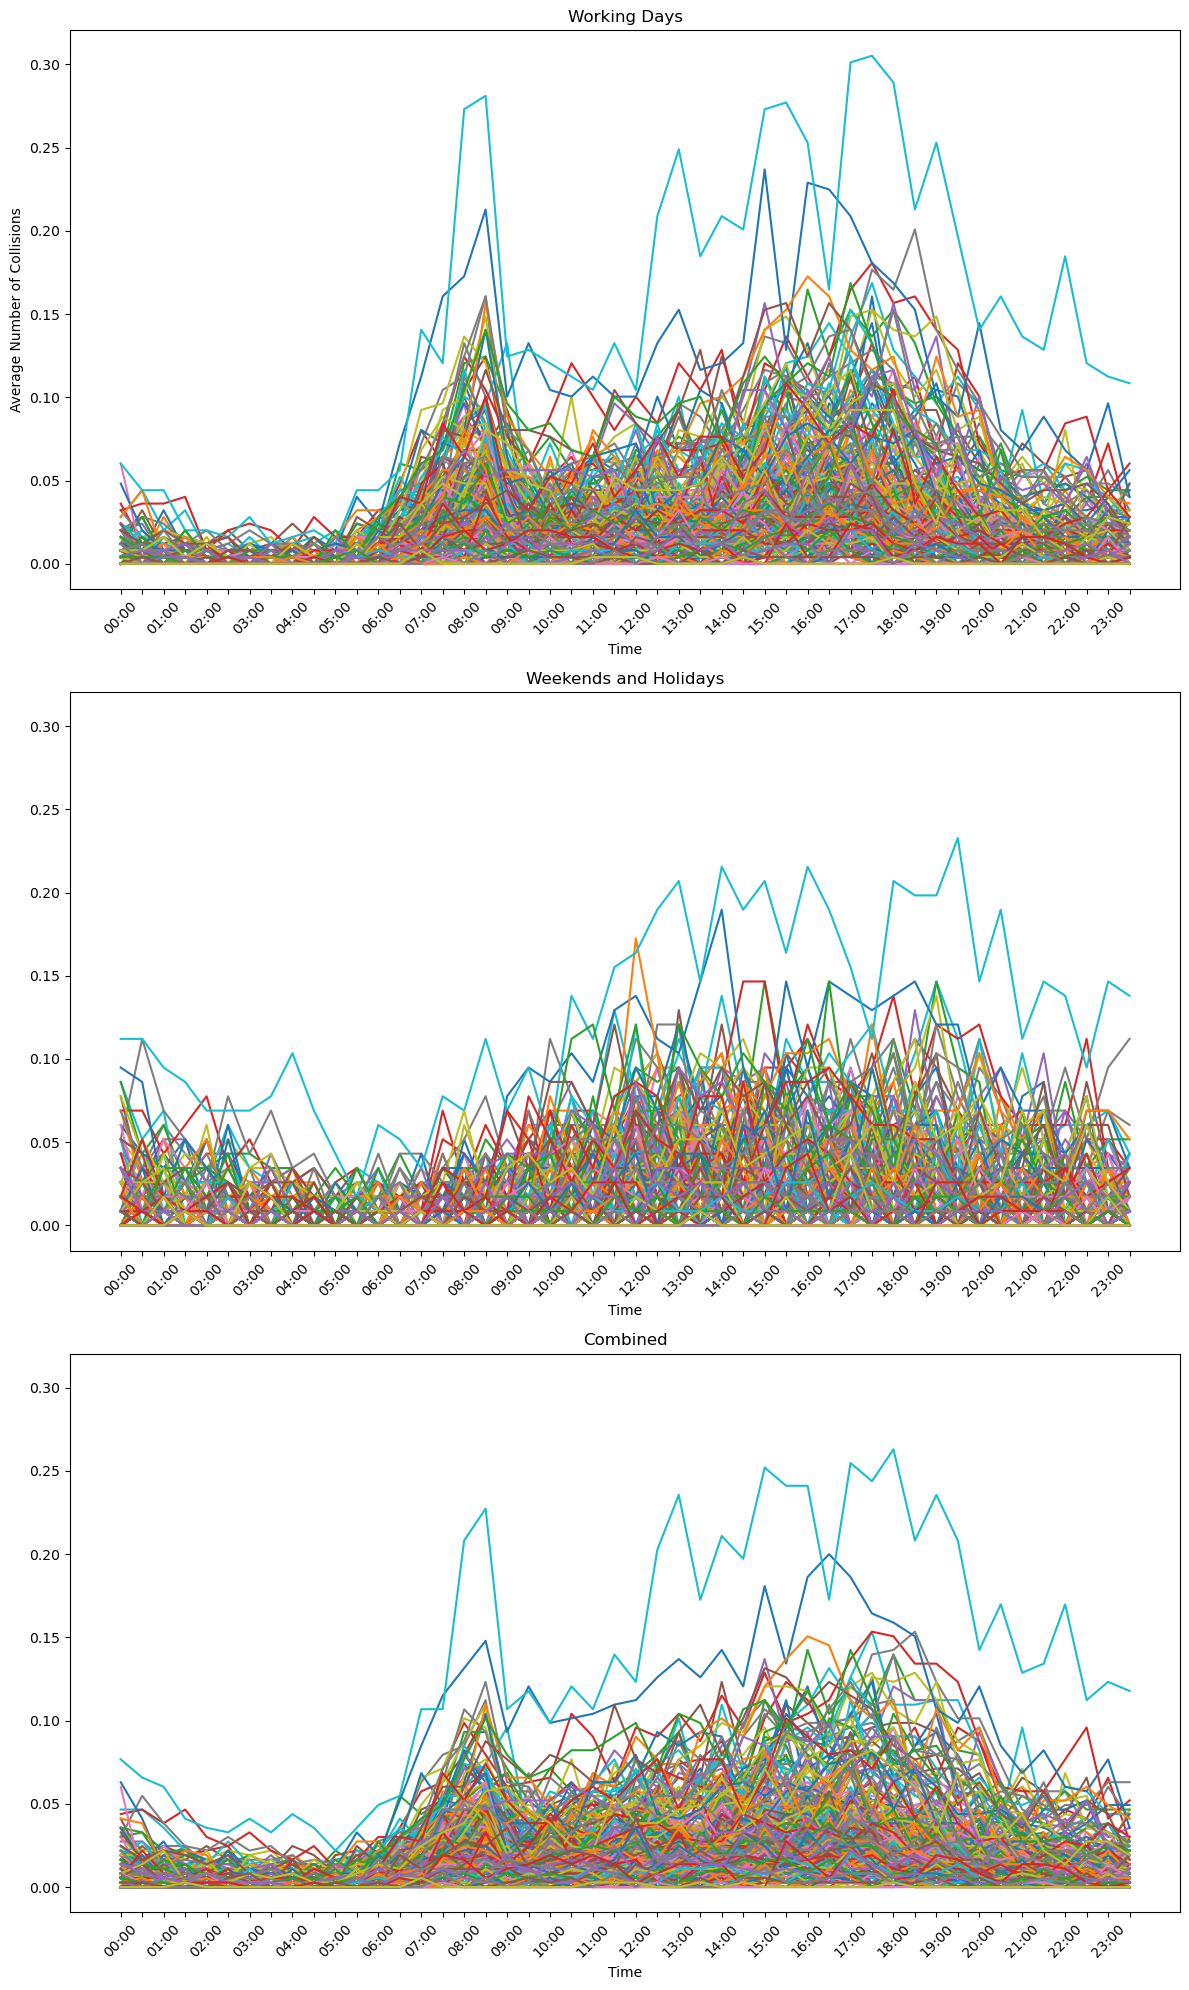

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Define a function to format the x-axis labels to show only the hour
def format_hour_only(x, pos):
    if x % 2 == 0:
        hour = int(x/2)
        return f'{hour:02d}:00'
    else:
        return ''


# Assuming `working_days_avg`, `weekends_holidays_avg`, and `combined_avg` DataFrames are already available
# Create a figure with three subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 20), sharey=True)

# Plot for working days
axes[0].plot(working_days_avg.index, working_days_avg)
axes[0].set_title('Working Days')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Average Number of Collisions')
axes[0].set_xticks(working_days_avg.index)
axes[0].xaxis.set_major_formatter(plt.FuncFormatter(format_hour_only))
axes[0].tick_params(axis='x', rotation=45)

# Plot for weekends and holidays
axes[1].plot(weekends_holidays_avg.index, weekends_holidays_avg)
axes[1].set_title('Weekends and Holidays')
axes[1].set_xlabel('Time')
axes[1].set_xticks(weekends_holidays_avg.index)
axes[1].xaxis.set_major_formatter(plt.FuncFormatter(format_hour_only))
axes[1].tick_params(axis='x', rotation=45)

# Plot combined
axes[2].plot(combined_avg.index, combined_avg)
axes[2].set_title('Combined')
axes[2].set_xlabel('Time')
axes[2].set_xticks(combined_avg.index)
axes[2].xaxis.set_major_formatter(plt.FuncFormatter(format_hour_only))
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('fig/total_line_LAD.png')
plt.show()


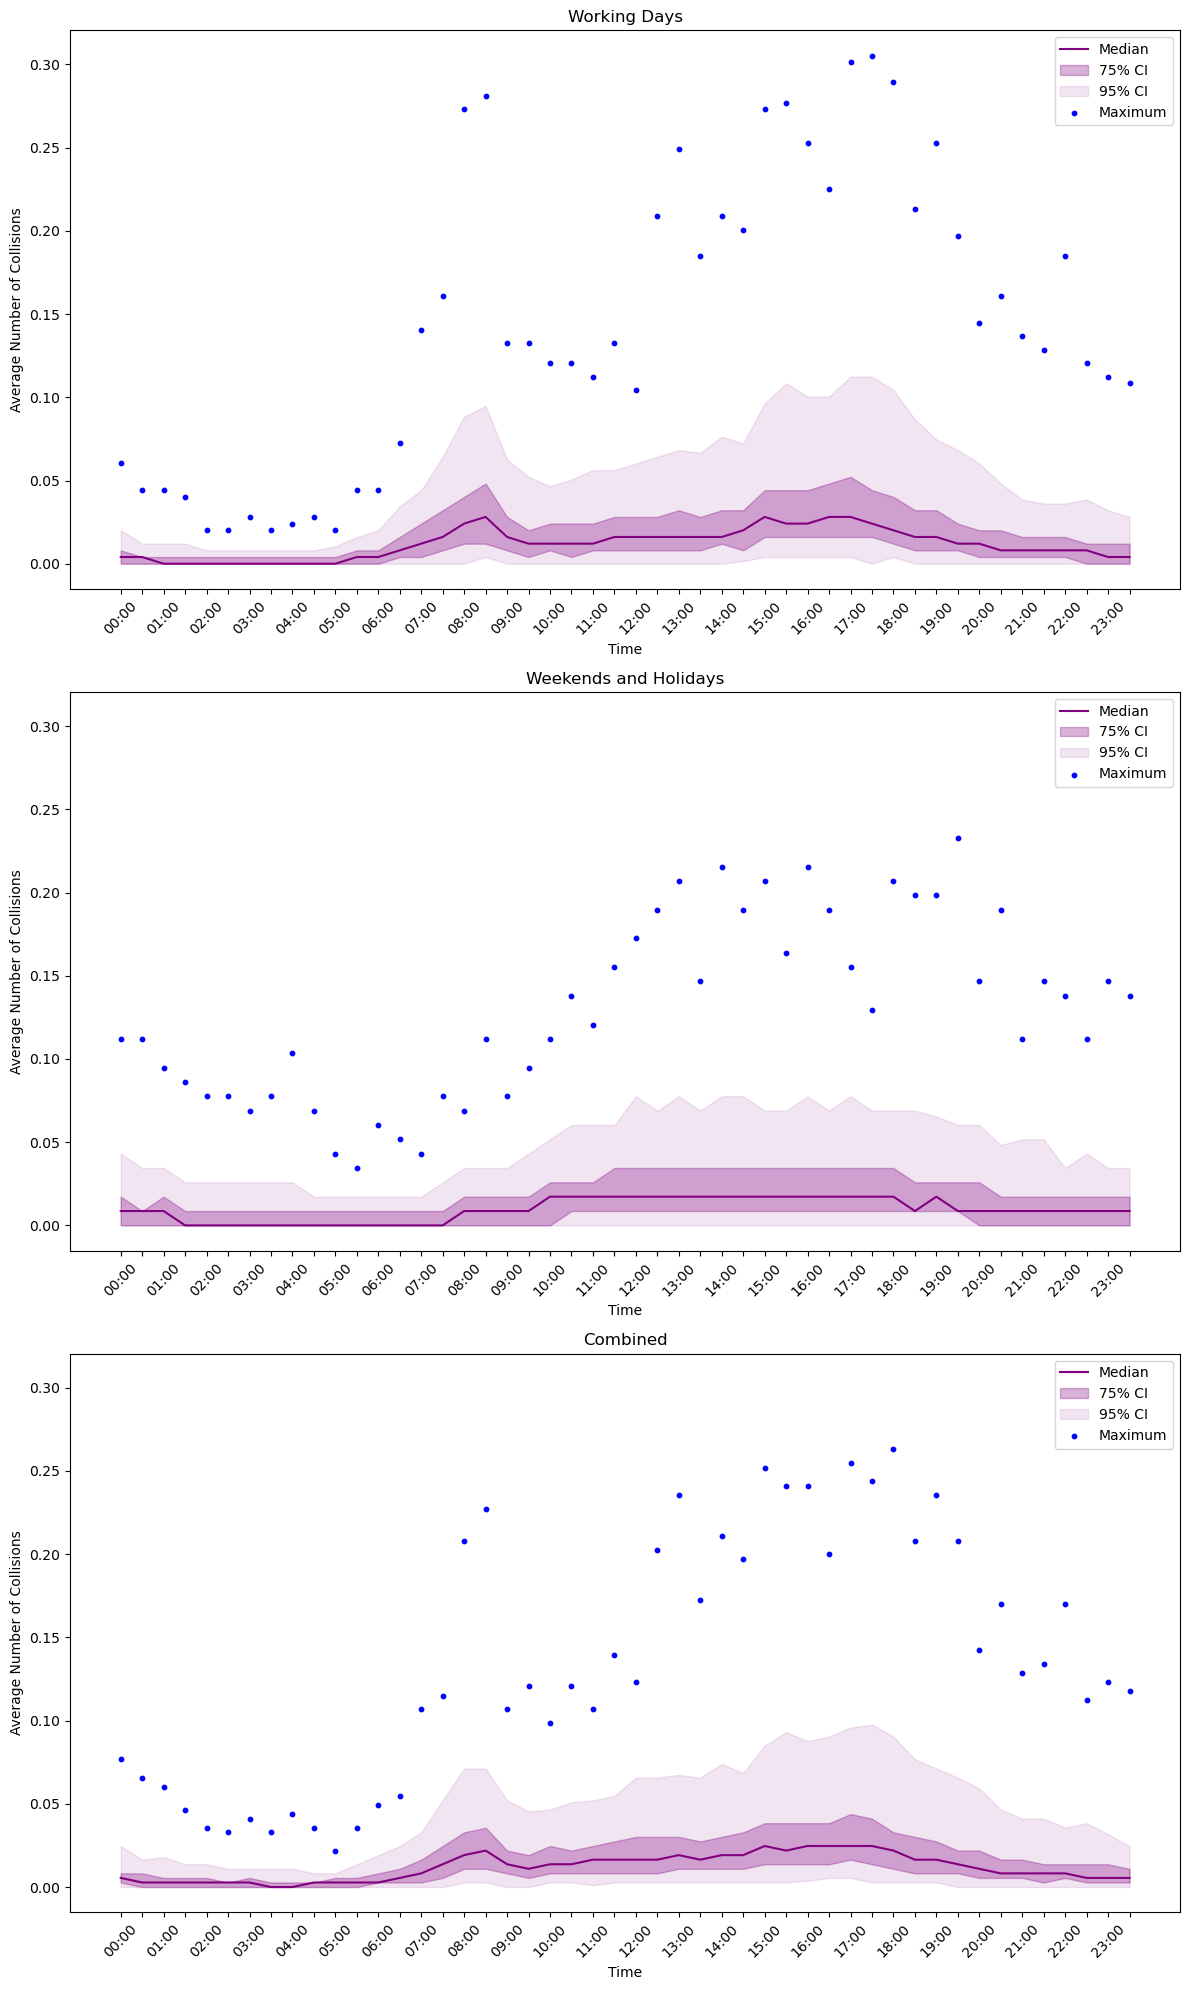

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have working_days_avg, weekends_holidays_avg, and combined_avg DataFrames

# Create a figure with three subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 20), sharey=True)

# Define a function to format the x-axis labels to show only the hour
def format_hour_only(x, pos):
    if x % 2 == 0:
        hour = int(x/2)
        return f'{hour:02d}:00'
    else:
        return ''

# Helper function to plot with confidence intervals
def plot_with_ci(ax, data, title):
    median = data.median(axis=1)
    q1 = data.quantile(0.25, axis=1)
    q3 = data.quantile(0.75, axis=1)
    q05 = data.quantile(0.05, axis=1)
    q95 = data.quantile(0.95, axis=1)
    min_val = data.min(axis=1)
    max_val = data.max(axis=1)
    
    ax.plot(median.index, median, color='purple', label='Median')
    ax.fill_between(median.index, q1, q3, color='purple', alpha=0.3, label='75% CI')
    ax.fill_between(median.index, q05, q95, color='purple', alpha=0.1, label='95% CI')
    ax.scatter(median.index, max_val, color='blue', s=10, label='Maximum')
    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Average Number of Collisions')
    ax.set_xticks(median.index)
    ax.xaxis.set_major_formatter(plt.FuncFormatter(format_hour_only))
    ax.tick_params(axis='x', rotation=45)
    ax.legend()

# Plot for working days
plot_with_ci(axes[0], working_days_avg, 'Working Days')

# Plot for weekends and holidays
plot_with_ci(axes[1], weekends_holidays_avg, 'Weekends and Holidays')

# Plot combined
plot_with_ci(axes[2], combined_avg, 'Combined')

plt.tight_layout()
plt.savefig('fig/total_line_LAD_ci.png')
plt.show()


In [21]:
# Flatten the DataFrames by resetting the index
working_days_avg_flat = working_days_avg.reset_index()
weekends_holidays_avg_flat = weekends_holidays_avg.reset_index()
combined_avg_flat = combined_avg.reset_index()

working_days_avg_flat = np.transpose(working_days_avg)
weekends_holidays_avg_flat = np.transpose(weekends_holidays_avg)
combined_avg_flat = np.transpose(combined_avg)
working_days_index = working_days_avg_flat.index

# Rename the columns to indicate the type of day
working_days_avg_flat.columns = [f'work_{col}' for col in working_days_avg_flat.columns]
weekends_holidays_avg_flat.columns = [f'weekend_{col}' for col in weekends_holidays_avg_flat.columns]
combined_avg_flat.columns = [f'combined_{col}' for col in combined_avg_flat.columns]

# Concatenate the DataFrames
merged_df = pd.concat([working_days_avg_flat, weekends_holidays_avg_flat, combined_avg_flat], axis=1)


In [22]:
merged_df

work_00:00  work_00:30  work_01:00  work_01:30  work_02:00  \
E09000013    0.000000    0.004016    0.000000    0.012048    0.004016   
E09000011    0.016064    0.004016    0.028112    0.008032    0.012048   
E09000004    0.000000    0.004016    0.000000    0.008032    0.004016   
E09000010    0.036145    0.012048    0.020080    0.016064    0.012048   
E09000026    0.016064    0.008032    0.000000    0.012048    0.000000   
...               ...         ...         ...         ...         ...   
S12000010    0.000000    0.000000    0.004016    0.004016    0.000000   
S12000045    0.000000    0.004016    0.000000    0.000000    0.000000   
S12000027    0.000000    0.000000    0.000000    0.000000    0.000000   
S12000039    0.000000    0.000000    0.000000    0.000000    0.000000   
S12000013    0.000000    0.000000    0.000000    0.000000    0.000000   

           work_02:30  work_03:00  work_03:30  work_04:00  work_04:30  ...  \
E09000013    0.000000    0.000000    0.004016    0.004016    0.004016  ...   
E09000011    0.016064    0.000000    0.000000    0.012048    0.004016  ...   
E09000004    0.004016    0.000000    0.000000    0.004016    0.000000  ...   
E09000010    0.016064    0.000000    0.004016    0.008032    0.000000  ...   
E09000026    0.000000    0.008032    0.012048    0.004016    0.012048  ...   
...               ...         ...         ...         ...         ...  ...   
S12000010    0.000000    0.000000    0.000000    0.000000    0.000000  ...   
S12000045    0.000000    0.000000    0.000000    0.000000    0.000000  ...   
S12000027    0.000000    0.000000    0.000000    0.000000    0.000000  ...   
S12000039    0.000000    0.000000    0.000000    0.000000    0.000000  ...   
S12000013    0.000000    0.000000    0.000000    0.000000    0.000000  ...   

           combined_19:00  combined_19:30  combined_20:00  combined_20:30  \
E09000013        0.032877        0.038356        0.049315        0.038356   
E09000011        0.046575        0.052055        0.043836        0.043836   
E09000004        0.057534        0.016438        0.038356        0.008219   
E09000010        0.065753        0.095890        0.087671        0.052055   
E09000026        0.049315        0.046575        0.043836        0.052055   
...                   ...             ...             ...             ...   
S12000010        0.005479        0.005479        0.002740        0.002740   
S12000045        0.005479        0.000000        0.005479        0.000000   
S12000027        0.000000        0.000000        0.000000        0.000000   
S12000039        0.002740        0.008219        0.000000        0.000000   
S12000013        0.000000        0.000000        0.000000        0.000000   

           combined_21:00  combined_21:30  combined_22:00  combined_22:30  \
E09000013        0.038356        0.043836        0.013699        0.027397   
E09000011        0.027397        0.030137        0.030137        0.024658   
E09000004        0.008219        0.013699        0.016438        0.010959   
E09000010        0.060274        0.035616        0.046575        0.041096   
E09000026        0.030137        0.038356        0.035616        0.041096   
...                   ...             ...             ...             ...   
S12000010        0.000000        0.000000        0.000000        0.002740   
S12000045        0.000000        0.000000        0.002740        0.000000   
S12000027        0.002740        0.002740        0.000000        0.000000   
S12000039        0.002740        0.005479        0.002740        0.000000   
S12000013        0.000000        0.000000        0.000000        0.000000   

           combined_23:00  combined_23:30  
E09000013        0.024658        0.008219  
E09000011        0.019178        0.016438  
E09000004        0.019178        0.021918  
E09000010        0.065753        0.027397  
E09000026        0.030137        0.030137  
...                   ...             ...  
S12000010        0.005479        0.0027

In [23]:
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(merged_df)


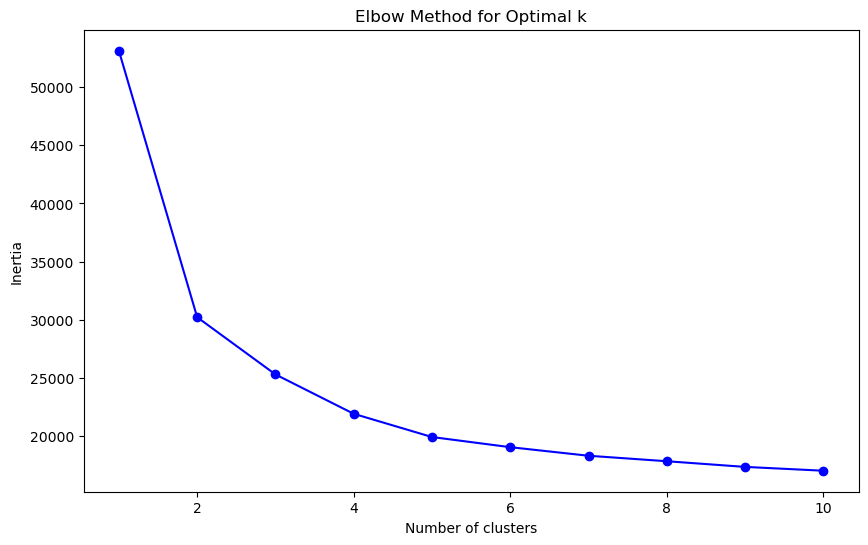

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Assuming `working_days_avg`, `weekends_holidays_avg`, and `combined_avg` DataFrames are already available
# Elbow Method to determine the optimal number of clusters
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_data)
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.savefig('fig/elbow.png')
plt.show()


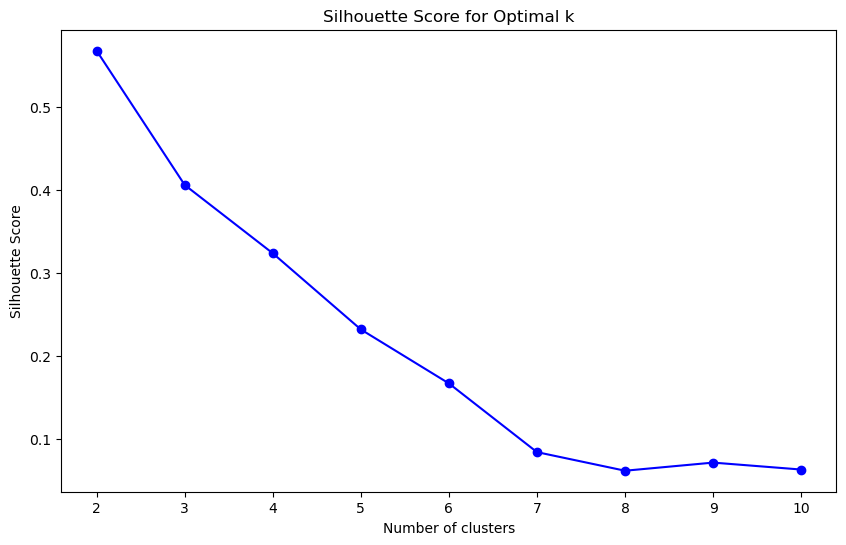

In [25]:
# Silhouette Score to determine the optimal number of clusters
silhouette_scores = []
K = range(2, 11)  # Silhouette score is not defined for k=1
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(normalized_data)
    score = silhouette_score(normalized_data, clusters)
    silhouette_scores.append(score)

# Plot the Silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.savefig('fig/silhouette.png')
plt.show()


In [26]:
merged_df

work_00:00  work_00:30  work_01:00  work_01:30  work_02:00  \
E09000013    0.000000    0.004016    0.000000    0.012048    0.004016   
E09000011    0.016064    0.004016    0.028112    0.008032    0.012048   
E09000004    0.000000    0.004016    0.000000    0.008032    0.004016   
E09000010    0.036145    0.012048    0.020080    0.016064    0.012048   
E09000026    0.016064    0.008032    0.000000    0.012048    0.000000   
...               ...         ...         ...         ...         ...   
S12000010    0.000000    0.000000    0.004016    0.004016    0.000000   
S12000045    0.000000    0.004016    0.000000    0.000000    0.000000   
S12000027    0.000000    0.000000    0.000000    0.000000    0.000000   
S12000039    0.000000    0.000000    0.000000    0.000000    0.000000   
S12000013    0.000000    0.000000    0.000000    0.000000    0.000000   

           work_02:30  work_03:00  work_03:30  work_04:00  work_04:30  ...  \
E09000013    0.000000    0.000000    0.004016    0.004016    0.004016  ...   
E09000011    0.016064    0.000000    0.000000    0.012048    0.004016  ...   
E09000004    0.004016    0.000000    0.000000    0.004016    0.000000  ...   
E09000010    0.016064    0.000000    0.004016    0.008032    0.000000  ...   
E09000026    0.000000    0.008032    0.012048    0.004016    0.012048  ...   
...               ...         ...         ...         ...         ...  ...   
S12000010    0.000000    0.000000    0.000000    0.000000    0.000000  ...   
S12000045    0.000000    0.000000    0.000000    0.000000    0.000000  ...   
S12000027    0.000000    0.000000    0.000000    0.000000    0.000000  ...   
S12000039    0.000000    0.000000    0.000000    0.000000    0.000000  ...   
S12000013    0.000000    0.000000    0.000000    0.000000    0.000000  ...   

           combined_19:00  combined_19:30  combined_20:00  combined_20:30  \
E09000013        0.032877        0.038356        0.049315        0.038356   
E09000011        0.046575        0.052055        0.043836        0.043836   
E09000004        0.057534        0.016438        0.038356        0.008219   
E09000010        0.065753        0.095890        0.087671        0.052055   
E09000026        0.049315        0.046575        0.043836        0.052055   
...                   ...             ...             ...             ...   
S12000010        0.005479        0.005479        0.002740        0.002740   
S12000045        0.005479        0.000000        0.005479        0.000000   
S12000027        0.000000        0.000000        0.000000        0.000000   
S12000039        0.002740        0.008219        0.000000        0.000000   
S12000013        0.000000        0.000000        0.000000        0.000000   

           combined_21:00  combined_21:30  combined_22:00  combined_22:30  \
E09000013        0.038356        0.043836        0.013699        0.027397   
E09000011        0.027397        0.030137        0.030137        0.024658   
E09000004        0.008219        0.013699        0.016438        0.010959   
E09000010        0.060274        0.035616        0.046575        0.041096   
E09000026        0.030137        0.038356        0.035616        0.041096   
...                   ...             ...             ...             ...   
S12000010        0.000000        0.000000        0.000000        0.002740   
S12000045        0.000000        0.000000        0.002740        0.000000   
S12000027        0.002740        0.002740        0.000000        0.000000   
S12000039        0.002740        0.005479        0.002740        0.000000   
S12000013        0.000000        0.000000        0.000000        0.000000   

           combined_23:00  combined_23:30  
E09000013        0.024658        0.008219  
E09000011        0.019178        0.016438  
E09000004        0.019178        0.021918  
E09000010        0.065753        0.027397  
E09000026        0.030137        0.030137  
...                   ...             ...  
S12000010        0.005479        0.0027

K-Means Silhouette Score with 2 Cluster: 0.5677046681434499
K-Means Silhouette Score with 3 Cluster: 0.4059934627892771
K-Means Silhouette Score with 3 Cluster: 0.3236930733552379
DBSCAN Silhouette Score: 0.8296402117790271
K-Means Number of Clusters: 2
K-Means Number of Clusters: 3
DBSCAN Number of Clusters: 2


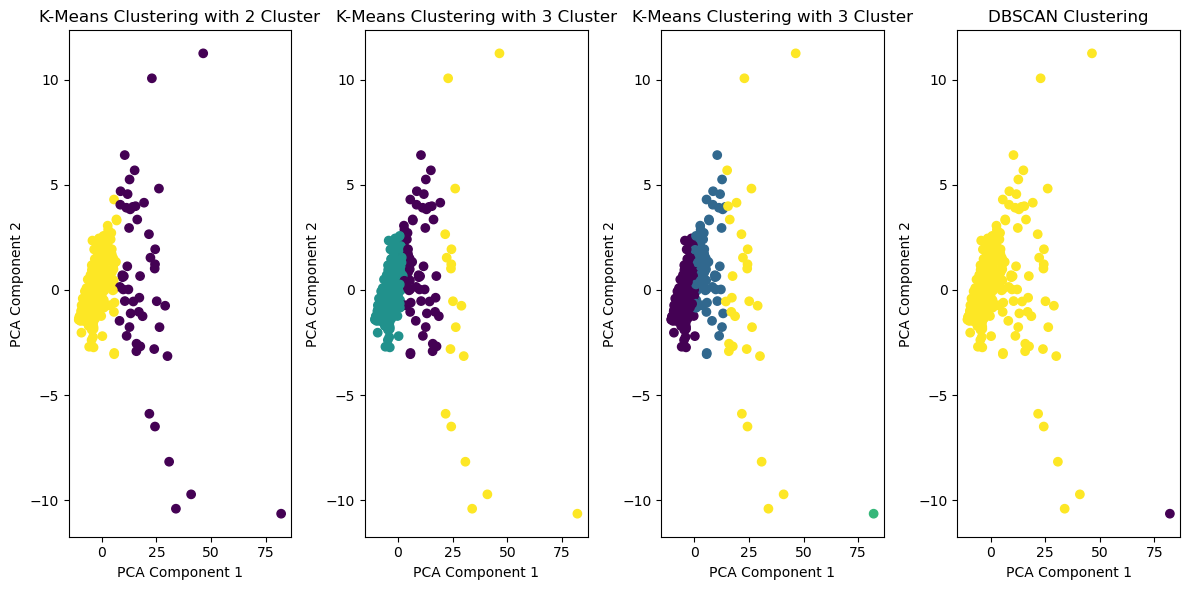

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.decomposition import PCA

# Assuming `working_days_avg`, `weekends_holidays_avg`, and `combined_avg` DataFrames are already available
# Normalize the data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(merged_df)

# Apply K-Means with the optimal number of clusters (assuming optimal_k is found previously)
optimal_k1 = 2  # Replace with the actual optimal number of clusters
kmeans1 = KMeans(n_clusters=optimal_k1, random_state=42)
kmeans_clusters1 = kmeans1.fit_predict(normalized_data)

# Evaluate K-Means
kmeans1_silhouette_score = silhouette_score(normalized_data, kmeans_clusters1)
print(f"K-Means Silhouette Score with 2 Cluster: {kmeans1_silhouette_score}")

# Apply K-Means with the optimal number of clusters (assuming optimal_k is found previously)
optimal_k2 = 3  # Replace with the actual optimal number of clusters
kmeans2 = KMeans(n_clusters=optimal_k2, random_state=42)
kmeans_clusters2 = kmeans2.fit_predict(normalized_data)

# Evaluate K-Means
kmeans2_silhouette_score = silhouette_score(normalized_data, kmeans_clusters2)
print(f"K-Means Silhouette Score with 3 Cluster: {kmeans2_silhouette_score}")

# Apply K-Means with the optimal number of clusters (assuming optimal_k is found previously)
optimal_k3 = 4  # Replace with the actual optimal number of clusters
kmeans3 = KMeans(n_clusters=optimal_k3, random_state=42)
kmeans_clusters3 = kmeans3.fit_predict(normalized_data)

# Evaluate K-Means
kmeans3_silhouette_score = silhouette_score(normalized_data, kmeans_clusters3)
print(f"K-Means Silhouette Score with 3 Cluster: {kmeans3_silhouette_score}")

# Apply DBSCAN
dbscan = DBSCAN(eps=0.6, min_samples=2)  # Adjust eps and min_samples as needed
dbscan_clusters = dbscan.fit_predict(merged_df)

# Evaluate DBSCAN
dbscan_silhouette_score = silhouette_score(normalized_data, dbscan_clusters) if len(set(dbscan_clusters)) > 1 else -1
print(f"DBSCAN Silhouette Score: {dbscan_silhouette_score}")

# Compare the number of clusters
print(f"K-Means Number of Clusters: {len(set(kmeans_clusters1))}")
print(f"K-Means Number of Clusters: {len(set(kmeans_clusters2))}")
print(f"DBSCAN Number of Clusters: {len(set(dbscan_clusters))}")

# Visualize the clusters using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(normalized_data)

plt.figure(figsize=(12, 6))

# K-Means Clustering_2
plt.subplot(1, 4, 1)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans_clusters1, cmap='viridis', marker='o')
plt.title('K-Means Clustering with 2 Cluster')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# K-Means Clustering_3
plt.subplot(1, 4, 2)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans_clusters2, cmap='viridis', marker='o')
plt.title('K-Means Clustering with 3 Cluster')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# K-Means Clustering_3
plt.subplot(1, 4, 3)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans_clusters3, cmap='viridis', marker='o')
plt.title('K-Means Clustering with 3 Cluster')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# DBSCAN Clustering
plt.subplot(1, 4, 4)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=dbscan_clusters, cmap='viridis', marker='o')
plt.title('DBSCAN Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.tight_layout()
plt.savefig('fig/clustering_comparison.png')
plt.show()


In [28]:
from sklearn.cluster import KMeans

# Determine the number of clusters (k)
k = 2  # This can be adjusted based on domain knowledge or using methods like the elbow method

# Apply K-Means clustering
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(normalized_data)

# Add cluster labels to the DataFrame
merged_df['Cluster'] = clusters


In [29]:
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

X = merged_df.drop(columns=['Cluster']).values

def perform_dbscan(X, eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X)
    # Check if the clustering produced more than 1 cluster
    if len(set(labels)) > 1:
        score = silhouette_score(X, labels)
    else:
        score = -1  # Not a valid score, as DBSCAN failed to form clusters
    return labels, score

eps_values = np.arange(0.1, 1.5, 0.1)
min_samples_values = range(2, 30)

best_score = -1
best_params = None
best_labels = None

for eps in eps_values:
    for min_samples in min_samples_values:
        labels, score = perform_dbscan(X, eps, min_samples)
        if score > best_score:
            best_score = score
            best_params = (eps, min_samples)
            best_labels = labels

print(f"Best parameters: eps = {best_params[0]:.1f}, min_samples = {best_params[1]}, best silhouette score: {best_score:.3f}")

# Add the best cluster labels to the original DataFrame
merged_df['DBSCAN_Cluster'] = best_labels

# Save the DataFrame with the new cluster labels if needed
merged_df.to_csv('path_to_merged_df_with_dbscan.csv', index=False)


Best parameters: eps = 0.6, min_samples = 2, best silhouette score: 0.835


In [30]:
merged_df

work_00:00  work_00:30  work_01:00  work_01:30  work_02:00  \
E09000013    0.000000    0.004016    0.000000    0.012048    0.004016   
E09000011    0.016064    0.004016    0.028112    0.008032    0.012048   
E09000004    0.000000    0.004016    0.000000    0.008032    0.004016   
E09000010    0.036145    0.012048    0.020080    0.016064    0.012048   
E09000026    0.016064    0.008032    0.000000    0.012048    0.000000   
...               ...         ...         ...         ...         ...   
S12000010    0.000000    0.000000    0.004016    0.004016    0.000000   
S12000045    0.000000    0.004016    0.000000    0.000000    0.000000   
S12000027    0.000000    0.000000    0.000000    0.000000    0.000000   
S12000039    0.000000    0.000000    0.000000    0.000000    0.000000   
S12000013    0.000000    0.000000    0.000000    0.000000    0.000000   

           work_02:30  work_03:00  work_03:30  work_04:00  work_04:30  ...  \
E09000013    0.000000    0.000000    0.004016    0.004016    0.004016  ...   
E09000011    0.016064    0.000000    0.000000    0.012048    0.004016  ...   
E09000004    0.004016    0.000000    0.000000    0.004016    0.000000  ...   
E09000010    0.016064    0.000000    0.004016    0.008032    0.000000  ...   
E09000026    0.000000    0.008032    0.012048    0.004016    0.012048  ...   
...               ...         ...         ...         ...         ...  ...   
S12000010    0.000000    0.000000    0.000000    0.000000    0.000000  ...   
S12000045    0.000000    0.000000    0.000000    0.000000    0.000000  ...   
S12000027    0.000000    0.000000    0.000000    0.000000    0.000000  ...   
S12000039    0.000000    0.000000    0.000000    0.000000    0.000000  ...   
S12000013    0.000000    0.000000    0.000000    0.000000    0.000000  ...   

           combined_20:00  combined_20:30  combined_21:00  combined_21:30  \
E09000013        0.049315        0.038356        0.038356        0.043836   
E09000011        0.043836        0.043836        0.027397        0.030137   
E09000004        0.038356        0.008219        0.008219        0.013699   
E09000010        0.087671        0.052055        0.060274        0.035616   
E09000026        0.043836        0.052055        0.030137        0.038356   
...                   ...             ...             ...             ...   
S12000010        0.002740        0.002740        0.000000        0.000000   
S12000045        0.005479        0.000000        0.000000        0.000000   
S12000027        0.000000        0.000000        0.002740        0.002740   
S12000039        0.000000        0.000000        0.002740        0.005479   
S12000013        0.000000        0.000000        0.000000        0.000000   

           combined_22:00  combined_22:30  combined_23:00  combined_23:30  \
E09000013        0.013699        0.027397        0.024658        0.008219   
E09000011        0.030137        0.024658        0.019178        0.016438   
E09000004        0.016438        0.010959        0.019178        0.021918   
E09000010        0.046575        0.041096        0.065753        0.027397   
E09000026        0.035616        0.041096        0.030137        0.030137   
...                   ...             ...             ...             ...   
S12000010        0.000000        0.002740        0.005479        0.002740   
S12000045        0.002740        0.000000        0.000000        0.000000   
S12000027        0.000000        0.000000        0.000000        0.000000   
S12000039        0.002740        0.000000        0.000000        0.000000   
S12000013        0.000000        0.000000        0.000000        0.000000   

           Cluster  DBSCAN_Cluster  
E09000013        0               0  
E09000011        0               0  
E09000004        1               0  
E09000010        0               0  
E09000026        0               0  
...            ...             ...  
S12000010        1               0  
S12000045        1               0  
S12000027     

In [31]:
merged_df.index.unique()

Index(['E09000013', 'E09000011', 'E09000004', 'E09000010', 'E09000026',
       'E09000025', 'E09000006', 'E09000014', 'E09000012', 'E09000030',
       ...
       'S12000030', 'S12000018', 'S12000020', 'S12000014', 'S12000034',
       'S12000010', 'S12000045', 'S12000027', 'S12000039', 'S12000013'],
      dtype='object', length=369)

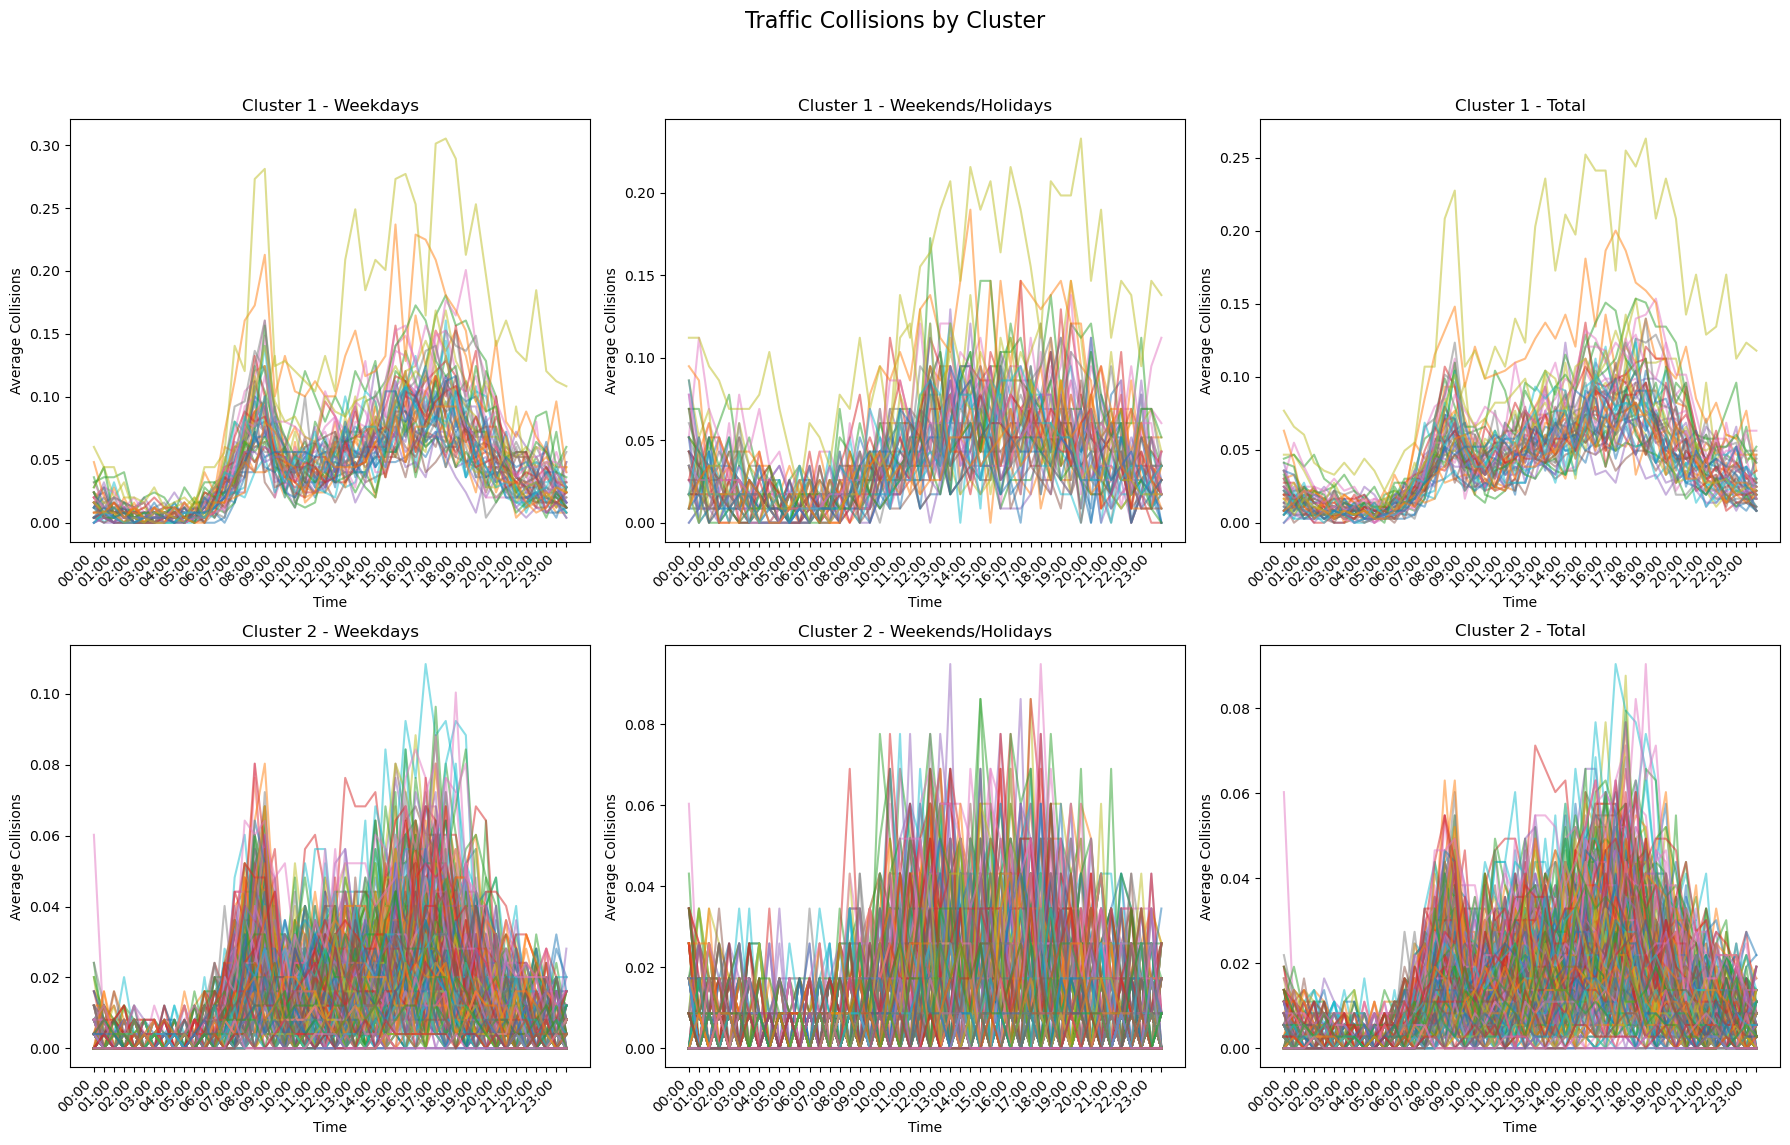

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Assuming merged_df is already available

# Define clusters
cluster_1 = merged_df[merged_df['Cluster'] == 0]
cluster_2 = merged_df[merged_df['Cluster'] == 1]
cluster_3 = merged_df[merged_df['Cluster'] == 2]

# Set up the subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
fig.suptitle('Traffic Collisions by Cluster', fontsize=16)

# Define a helper function to plot the data
def plot_traffic_collisions(ax, data, title, time_labels):
    for index, row in data.iterrows():
        ax.plot(time_labels, row, alpha=0.5)
    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Average Collisions')
    ax.grid(False)  # Turn off the grid
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    # Define a function to format the x-axis labels to show only the hour
    def format_hour_only(x, pos):
        if x % 2 == 0:
            hour = int(x / 2)
            return f'{hour:02d}:00'
        else:
            return ''

    # Set the x-axis ticks to every half-hour (assuming numeric index with half-hour intervals)
    ax.set_xticks(range(len(time_labels)))

    # Set the formatter to use the format_hour_only function
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_hour_only))

# Prepare the time labels
time_labels = [f"{hour:02}:{minute:02}" for hour in range(24) for minute in (0, 30)]

# Plot the data for each cluster and each category
# Cluster 1
plot_traffic_collisions(axes[0, 0], cluster_1.iloc[:, :48], 'Cluster 1 - Weekdays', time_labels)
plot_traffic_collisions(axes[0, 1], cluster_1.iloc[:, 48:96], 'Cluster 1 - Weekends/Holidays', time_labels)
plot_traffic_collisions(axes[0, 2], cluster_1.iloc[:, 96:144], 'Cluster 1 - Total', time_labels)

# Cluster 2
plot_traffic_collisions(axes[1, 0], cluster_2.iloc[:, :48], 'Cluster 2 - Weekdays', time_labels)
plot_traffic_collisions(axes[1, 1], cluster_2.iloc[:, 48:96], 'Cluster 2 - Weekends/Holidays', time_labels)
plot_traffic_collisions(axes[1, 2], cluster_2.iloc[:, 96:144], 'Cluster 2 - Total', time_labels)

# Adjust layout and show plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('fig/cluster_line.png')
plt.show()


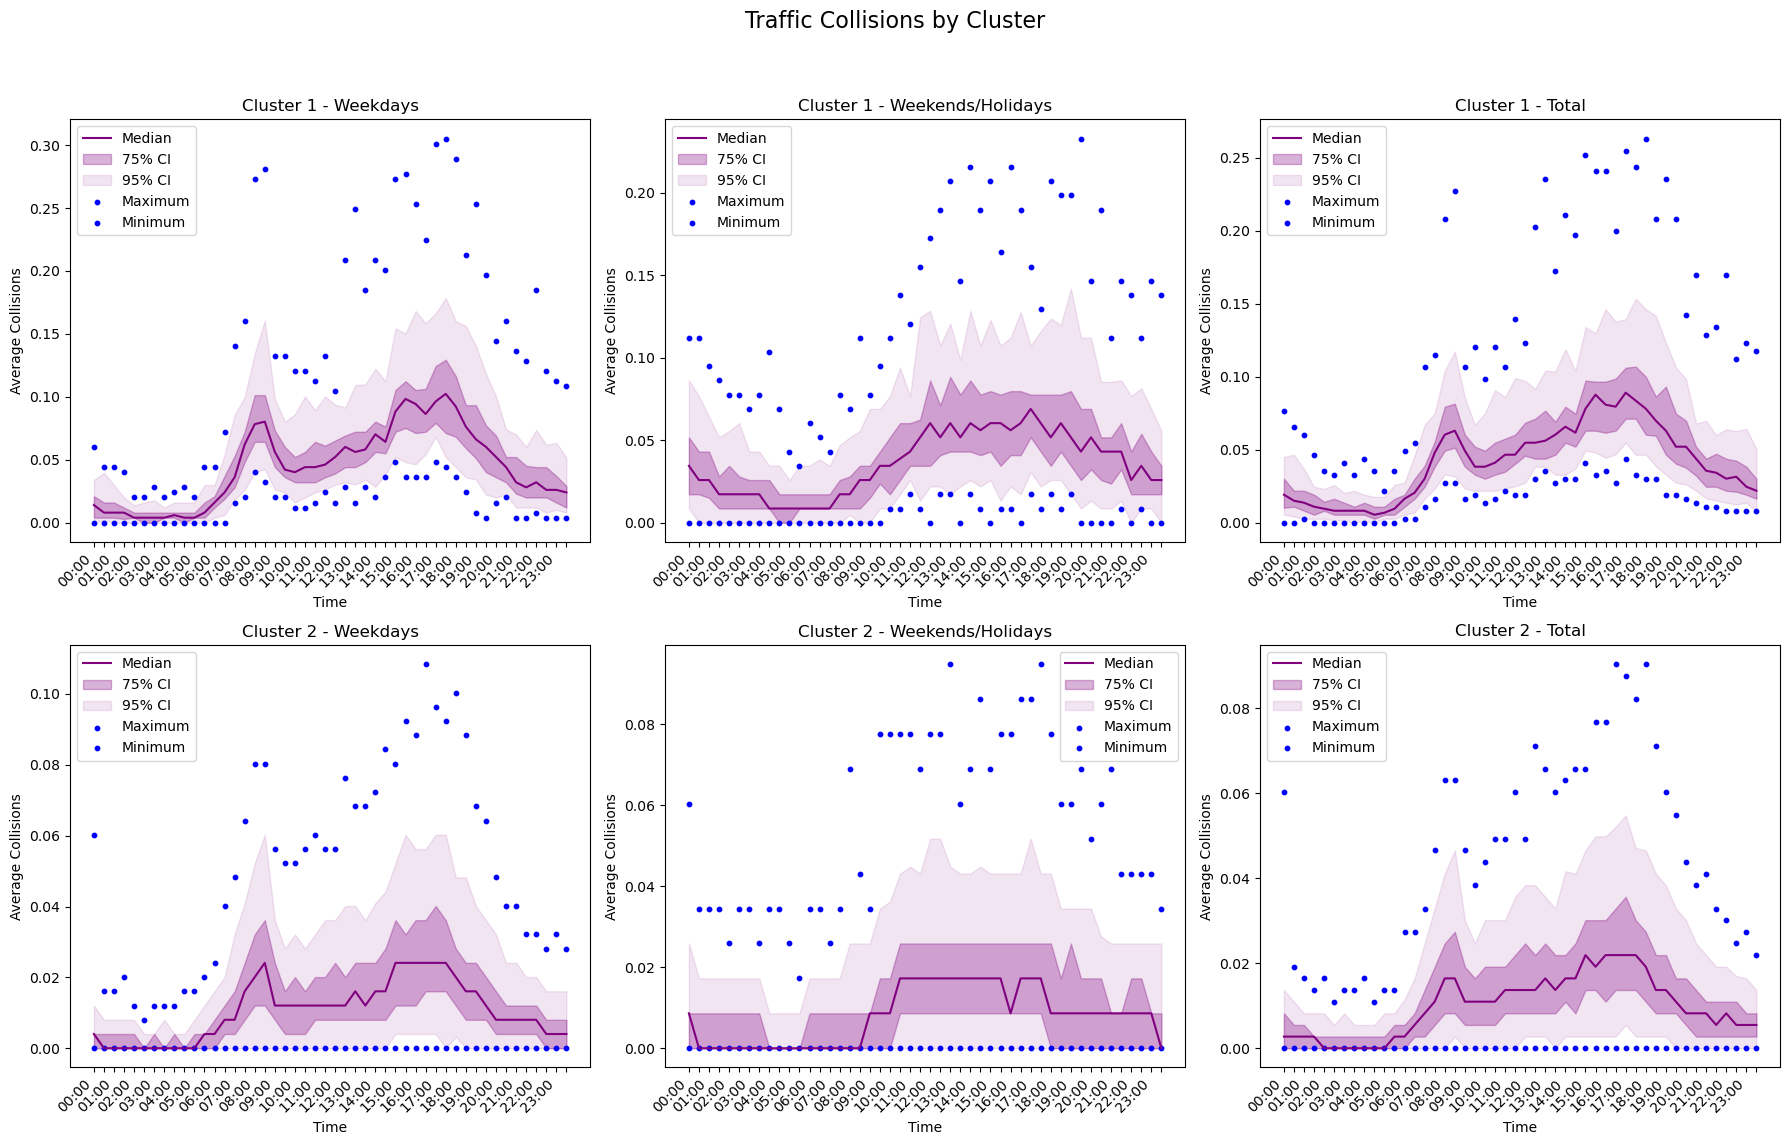

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Assuming merged_df is already available and contains numeric columns for time series data
# and non-numeric columns like 'Cluster' and region codes.

# Exclude non-numeric columns
numeric_columns = merged_df.select_dtypes(include=[float, int]).columns

# Define clusters
cluster_1 = merged_df[merged_df['Cluster'] == 0][numeric_columns]
cluster_2 = merged_df[merged_df['Cluster'] == 1][numeric_columns]
cluster_3 = merged_df[merged_df['Cluster'] == 2][numeric_columns]

# Set up the subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
fig.suptitle('Traffic Collisions by Cluster', fontsize=16)

# Prepare the time labels
time_labels = [f"{hour:02}:{minute:02}" for hour in range(24) for minute in (0, 30)]

# Define a helper function to plot the data with confidence intervals
def plot_traffic_collisions(ax, data, title, time_labels):
    # Calculate median, quartiles, min, max
    median = data.median(axis=0)
    q1 = data.quantile(0.25, axis=0)
    q3 = data.quantile(0.75, axis=0)
    q05 = data.quantile(0.05, axis=0)
    q95 = data.quantile(0.95, axis=0)
    min_val = data.min(axis=0)
    max_val = data.max(axis=0)
    
    # Plot median line
    ax.plot(time_labels, median, color='purple', label='Median')
    
    # Plot confidence intervals
    ax.fill_between(time_labels, q1, q3, color='purple', alpha=0.3, label='75% CI')
    ax.fill_between(time_labels, q05, q95, color='purple', alpha=0.1, label='95% CI')
    
    # Plot scatter for min and max
    ax.scatter(time_labels, max_val, color='blue', s=10, label='Maximum')
    ax.scatter(time_labels, min_val, color='blue', s=10, label='Minimum')
    
    # Set title and labels
    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Average Collisions')
    ax.grid(False)  # Turn off the grid
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    # Define a function to format the x-axis labels to show only the hour
    def format_hour_only(x, pos):
        if x % 2 == 0:
            hour = int(x / 2)
            return f'{hour:02d}:00'
        else:
            return ''

    # Set the x-axis ticks to every half-hour (assuming numeric index with half-hour intervals)
    ax.set_xticks(range(len(time_labels)))

    # Set the formatter to use the format_hour_only function
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_hour_only))
    
    # Add legend
    ax.legend()

# Plot the data for each cluster and each category
# Cluster 1
plot_traffic_collisions(axes[0, 0], cluster_1.iloc[:, :48], 'Cluster 1 - Weekdays', time_labels)
plot_traffic_collisions(axes[0, 1], cluster_1.iloc[:, 48:96], 'Cluster 1 - Weekends/Holidays', time_labels)
plot_traffic_collisions(axes[0, 2], cluster_1.iloc[:, 96:144], 'Cluster 1 - Total', time_labels)

# Cluster 2
plot_traffic_collisions(axes[1, 0], cluster_2.iloc[:, :48], 'Cluster 2 - Weekdays', time_labels)
plot_traffic_collisions(axes[1, 1], cluster_2.iloc[:, 48:96], 'Cluster 2 - Weekends/Holidays', time_labels)
plot_traffic_collisions(axes[1, 2], cluster_2.iloc[:, 96:144], 'Cluster 2 - Total', time_labels)

# Adjust layout and show plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('fig/cluster_line_ci.png')
plt.show()


In [34]:
# Count the occurrences of each unique value in the 'Cluster' column
cluster_counts = merged_df['Cluster'].value_counts()

# Print the counts
print(cluster_counts)

Cluster
1    317
0     52
Name: count, dtype: int64


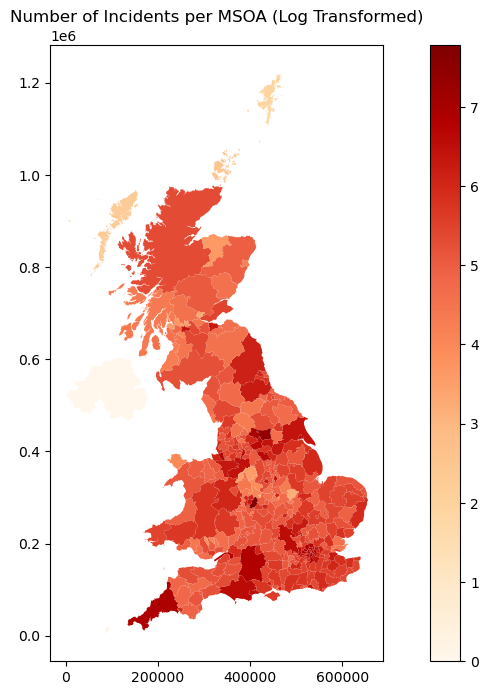

In [35]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Step 2: Count incidents per MSOA
incident_counts = collision['msoa_of_accident_location'].value_counts().reset_index()
incident_counts.columns = ['MSOA', 'incident_count']

# Ensure the MSOA codes are the same type
temp_msoa['MSOA'] = temp_msoa['geo_code'].astype(str)
incident_counts['MSOA'] = incident_counts['MSOA'].astype(str)

# Merge the dataframes
merged = temp_msoa.merge(incident_counts, on='MSOA', how='left')

# Step 3: Handle NaN values
merged['incident_count'] = merged['incident_count'].fillna(0)

# Assuming `merged` is your GeoDataFrame
# Apply log transformation to the 'incident_count' column
merged['log_incident_count'] = np.log1p(merged['incident_count'])  # log1p handles log(1 + x) to avoid log(0)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plot the log-transformed data without boundary lines
merged.plot(column='log_incident_count', cmap='OrRd', linewidth=0.1, ax=ax, edgecolor=None, legend=True)

ax.set_title('Number of Incidents per MSOA (Log Transformed)')

plt.savefig('fig/number_of_incidents_MSOA.png')
plt.show()

In [36]:
collision

accident_index  accident_year accident_reference  \
0       2022010352073           2022           10352073   
1       2022010352573           2022           10352573   
2       2022010352575           2022           10352575   
3       2022010352578           2022           10352578   
4       2022010352580           2022           10352580   
...               ...            ...                ...   
105999  2022991311627           2022          991311627   
106000  2022991312498           2022          991312498   
106001  2022991315177           2022          991315177   
106002  2022991321308           2022          991321308   
106003  2022991322411           2022          991322411   

        location_easting_osgr  location_northing_osgr  longitude   latitude  \
0                    525199.0                177928.0  -0.198224  51.486454   
1                    546214.0                179866.0   0.105042  51.498830   
2                    551119.0                174789.0   0.173482  51.451924   
3                    528889.0                192230.0  -0.139873  51.614153   
4                    539773.0                190404.0   0.016495  51.595151   
...                       ...                     ...        ...        ...   
105999               235016.0                625551.0  -4.613246  55.495815   
106000               127459.0                663067.0  -6.348650  55.783849   
106001               254396.0                663549.0  -4.326930  55.843114   
106002               325409.0                677054.0  -3.196963  55.980648   
106003               324745.0                673696.0  -3.206662  55.950381   

        police_force  accident_severity  number_of_vehicles  ...  \
0                  1                  3                   2  ...   
1                  1                  3                   2  ...   
2                  1                  3                   2  ...   
3                  1                  3                   2  ...   
4                  1                  3                   4  ...   
...              ...                ...                 ...  ...   
105999            99                  2                   1  ...   
106000            99                  2                   3  ...   
106001            99                  3                   1  ...   
106002            99                  2                   1  ...   
106003            99                  2                   1  ...   

        weather_conditions road_surface_conditions  \
0                        1                       1   
1                        1                       1   
2                        1                       1   
3                        1                       1   
4                        1                       1   
...                    ...                     ...   
105999                   1                       1   
106000                   1                       1   
106001                   1                       1   
106002                   1                       1   
106003                   1                       2   

        special_conditions_at_site carriageway_hazards  urban_or_rural_area  \
0                                0                   0                    1   
1                                0                   0                    2   
2                                0                   0                    1   
3                                0                   0                    1   
4                                0                   0                    1   
...                            ...                 ...                  ...   
105999                           0                   0                    1   
106000                           0                   0                    2   
106001                           0                   0                    1   
106002                           0                   0                    1   
106003        

In [37]:
merged

objectid_1   geo_code               lad20nm        lad20nmw   bng_e  \
0             1  E06000001            Hartlepool             NaN  447160   
1             2  E06000002         Middlesbrough             NaN  451141   
2             3  E06000003  Redcar and Cleveland             NaN  464361   
3             4  E06000004      Stockton-on-Tees             NaN  444940   
4             5  E06000005            Darlington             NaN  428029   
..          ...        ...                   ...             ...     ...   
374         375  W06000020               Torfaen         Torfaen  327459   
375         376  W06000021         Monmouthshire       Sir Fynwy  337812   
376         377  W06000022               Newport       Casnewydd  337897   
377         378  W06000023                 Powys           Powys  302329   
378         379  W06000024        Merthyr Tydfil  Merthyr Tudful  305916   

      bng_n     long        lat    st_areasha     st_lengths  \
0    531474 -1.27018  54.676140  9.834667e+07   66121.472650   
1    516887 -1.21099  54.544670  5.455359e+07   41055.809886   
2    519597 -1.00608  54.567520  2.537854e+08  105292.138896   
3    518183 -1.30664  54.556911  2.097308e+08  108085.255484   
4    515648 -1.56835  54.535339  1.974757e+08  107206.401677   
..      ...      ...        ...           ...            ...   
374  200480 -3.05101  51.698360  1.262399e+08   82544.775967   
375  209231 -2.90280  51.778271  8.860000e+08  250892.734308   
376  187432 -2.89769  51.582310  2.175180e+08  135651.645859   
377  273255 -3.43531  52.348640  5.195456e+09  606560.369136   
378  206424 -3.36425  51.748581  1.119570e+08   66696.929592   

                                 GlobalID  \
0    ba12d24f-5401-4f2f-82df-91fa6d4e77e8   
1    470e251c-3916-47bf-9ce1-50af29a1f15c   
2    e2b2983a-dd19-444b-a2ee-0ec5ab8484fe   
3    66f236f8-d480-49f9-9b78-89c48bd2723f   
4    6fb2e38a-6088-4c5f-bed8-662a6396ad43   
..                                    ...   
374  5da02fec-1148-4aa7-a11e-6fd1ac334b6b   
375  b4d36cca-119c-49ba-985c-774263e397ae   
376  0875e9dc-ab2a-4692-bacf-790497759467   
377  cbd1c8f1-d3a2-4b19-ac9d-b9dee9578639   
378  7a528f96-e9c6-4144-a751-d69a0494d7a2   

                                              geometry       MSOA  \
0    POLYGON ((447213.900 537036.104, 447228.798 53...  E06000001   
1    POLYGON ((448489.897 522071.798, 448592.597 52...  E06000002   
2    POLYGON ((455525.931 528406.654, 455724.632 52...  E06000003   
3    POLYGON ((444157.002 527956.304, 444165.898 52...  E06000004   
4    POLYGON ((423496.602 524724.299, 423497.204 52...  E06000005   
..                                                 ...        ...   
374  POLYGON ((323898.201 211287.499, 324115.698 21...  W06000020   
375  MULTIPOLYGON (((345806.401 180943.905, 345807....  W06000021   
376  POLYGON ((342211.900 194845.495, 342221.803 19...  W06000022   
377  POLYGON ((322392.901 334017.198, 322378.002 33...  W06000023   
378  POLYGON ((303435.502 214925.598, 303431.602 21...  W06000024   

     incident_count  log_incident_count  
0             125.0            4.836282  
1             209.0            5.347108  
2             135.0            4.912655  
3             205.0            5.327876  
4             114.0            4.744932  
..              ...                 ...  
374            83.0            4.430817  
375           102.0            4.634729  
376           187.0            5.236442  
377           315.0            5.755742  
378            43.0            3.784190  

[379 rows x 15 columns]

In [38]:
# Reset the index of merged_df to make geo_code a column
merged_df.reset_index(inplace=True)
merged_df.rename(columns={'index': 'geo_code'}, inplace=True)




In [39]:
# Merge the dataframes on the 'geo_code' column
merged_result = pd.merge(merged, merged_df[['geo_code', 'Cluster']], on='geo_code', how='left')

# Print out the number of rows in merged that do not match the corresponding cluster
non_matching_rows = merged_result['Cluster'].isnull().sum()
print(f'Number of rows in the second table that do not match the corresponding cluster: {non_matching_rows}')


Number of rows in the second table that do not match the corresponding cluster: 11


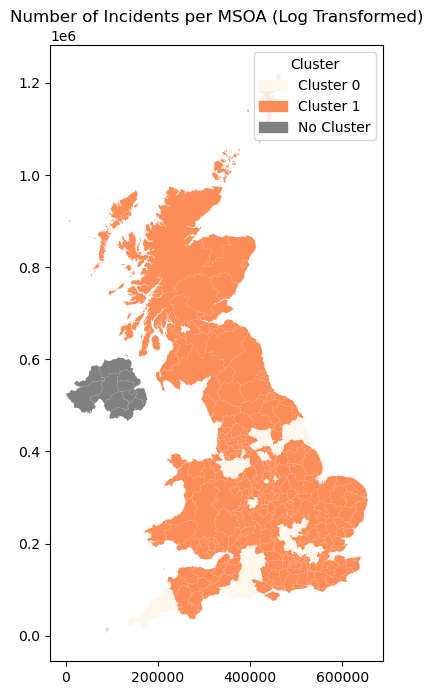

In [40]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import geopandas as gpd

# Sample data creation for demonstration purposes (remove this part if using actual dataframes)
# merged_result should already be your merged GeoDataFrame

# Replace NaN values in Cluster column with a specific value, e.g., -1
merged_result['Cluster'] = merged_result['Cluster'].fillna(-1)

# Define a colormap for the clusters
cmap = plt.cm.get_cmap('OrRd', 3)  # Get a colormap with 3 distinct colors
colors = {0: cmap(0), 1: cmap(1), -1: 'grey'}  # Map -1 (representing NaN) to grey color

# Create a color column based on Cluster values
merged_result['color'] = merged_result['Cluster'].map(colors)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plot the data without boundary lines
merged_result.plot(color=merged_result['color'], linewidth=0, ax=ax, edgecolor=None, legend=False)

# Add a custom legend
legend_labels = {
    0: 'Cluster 0',
    1: 'Cluster 1',
    -1: 'No Cluster'
}
handles = [mpatches.Patch(color=color, label=legend_labels[cluster]) for cluster, color in colors.items() if cluster in legend_labels]
ax.legend(handles=handles, loc='upper right', title='Cluster')

# Set the title
ax.set_title('Number of Incidents per MSOA (Log Transformed)')
plt.savefig('fig/visualization of cluster.png')
plt.show()


In [41]:
merged_df['geo_code']

0      E09000013
1      E09000011
2      E09000004
3      E09000010
4      E09000026
         ...    
364    S12000010
365    S12000045
366    S12000027
367    S12000039
368    S12000013
Name: geo_code, Length: 369, dtype: object

In [42]:
merged['geo_code']

0      E06000001
1      E06000002
2      E06000003
3      E06000004
4      E06000005
         ...    
374    W06000020
375    W06000021
376    W06000022
377    W06000023
378    W06000024
Name: geo_code, Length: 379, dtype: object

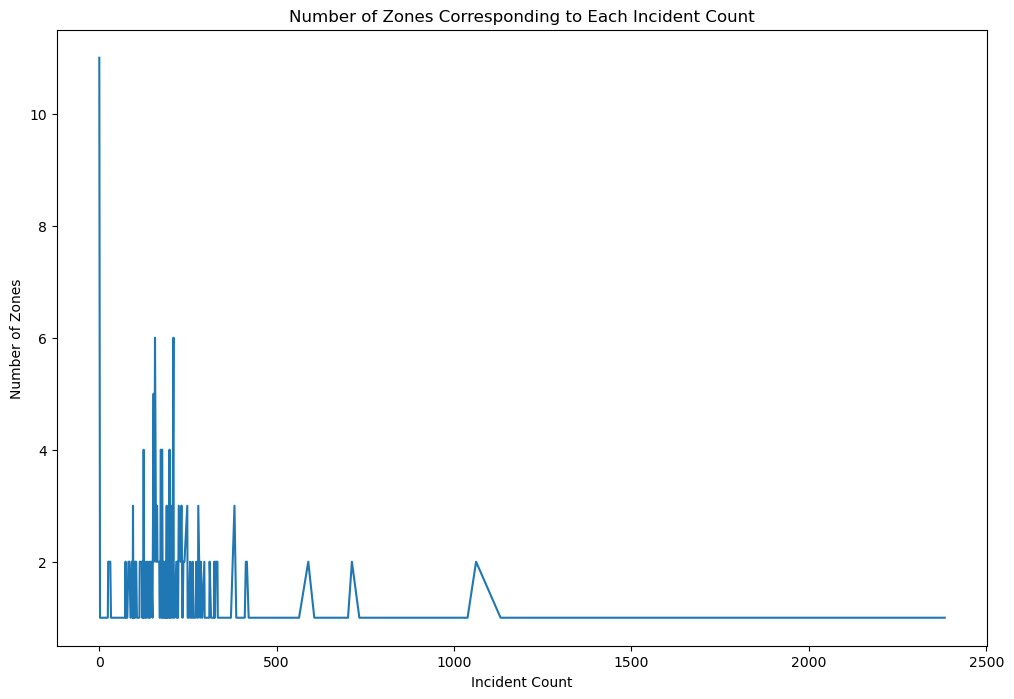

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'merged' is your DataFrame
# Calculate the frequency of each incident count
incident_counts = merged['incident_count'].value_counts().sort_index()

# Plot the data
plt.figure(figsize=(12, 8))
plt.plot(incident_counts.index, incident_counts.values, linestyle='-')
plt.xlabel('Incident Count')
plt.ylabel('Number of Zones')
plt.title('Number of Zones Corresponding to Each Incident Count')
plt.savefig('fig/power_law_of_incidents_MSOA.png')
plt.show()


In [44]:
collision_temp = collision.drop(columns=['accident_year', 'accident_reference', 'longitude', 'latitude', 'location_easting_osgr', 'location_northing_osgr', 'police_force'])

collision_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106004 entries, 0 to 106003
Data columns (total 31 columns):
 #   Column                                       Non-Null Count   Dtype         
---  ------                                       --------------   -----         
 0   accident_index                               106004 non-null  object        
 1   accident_severity                            106004 non-null  int64         
 2   number_of_vehicles                           106004 non-null  int64         
 3   number_of_casualties                         106004 non-null  int64         
 4   date                                         106004 non-null  datetime64[ns]
 5   day_of_week                                  106004 non-null  int64         
 6   time                                         106004 non-null  object        
 7   local_authority_district                     106004 non-null  int64         
 8   local_authority_ons_district                 106004 non-null  ob

In [45]:
collision_temp

accident_index  accident_severity  number_of_vehicles  \
0       2022010352073                  3                   2   
1       2022010352573                  3                   2   
2       2022010352575                  3                   2   
3       2022010352578                  3                   2   
4       2022010352580                  3                   4   
...               ...                ...                 ...   
105999  2022991311627                  2                   1   
106000  2022991312498                  2                   3   
106001  2022991315177                  3                   1   
106002  2022991321308                  2                   1   
106003  2022991322411                  2                   1   

        number_of_casualties       date  day_of_week      time  \
0                          1 2022-01-05            4  16:40:00   
1                          1 2022-01-01            7  01:17:00   
2                          1 2022-01-01            7  01:15:00   
3                          2 2022-01-01            7  02:24:00   
4                          3 2022-01-01            7  02:30:00   
...                      ...        ...          ...       ...   
105999                     1 2022-12-24            7  15:00:00   
106000                     1 2022-11-12            7  21:35:00   
106001                     1 2022-07-01            6  11:44:00   
106002                     1 2022-12-02            6  16:45:00   
106003                     1 2022-11-23            4  19:05:00   

        local_authority_district local_authority_ons_district  \
0                             -1                    E09000013   
1                             -1                    E09000011   
2                             -1                    E09000004   
3                             -1                    E09000010   
4                             -1                    E09000026   
...                          ...                          ...   
105999                        -1                    S12000028   
106000                        -1                    S12000035   
106001                        -1                    S12000049   
106002                        -1                    S12000036   
106003                        -1                    S12000036   

       local_authority_highway  ...  weather_conditions  \
0                    E09000013  ...                   1   
1                    E09000011  ...                   1   
2                    E09000004  ...                   1   
3                    E09000010  ...                   1   
4                    E09000026  ...                   1   
...                        ...  ...                 ...   
105999               S12000028  ...                   1   
106000               S12000035  ...                   1   
106001               S12000049  ...                   1   
106002               S12000036  ...                   1   
106003               S12000036  ...                   1   

        road_surface_conditions  special_conditions_at_site  \
0                             1                           0   
1                             1                           0   
2                             1                           0   
3                             1                           0   
4                             1                           0   
...                         ...                         ...   
105999                        1                           0   
106000                        1                           0   
106001                        1                           0   
106002                        1                           0   
106003                        2                           0   

        carriageway_hazards  urban_or_rural_area  \
0                         0                    1   
1                         0                    2   
2                         0               

In [46]:
type(merged)

geopandas.geodataframe.GeoDataFrame

In [47]:
import geopandas as gpd
from esda.moran import Moran
from libpysal.weights import Queen

# Calculate spatial weights matrix
w = Queen.from_dataframe(merged)

# Calculate Moran's I
moran = Moran(merged['incident_count'], w)
print(f"Moran's I: {moran.I}, p-value: {moran.p_sim}")


('WARNING: ', 25, ' is an island (no neighbors)')
('WARNING: ', 43, ' is an island (no neighbors)')
('WARNING: ', 49, ' is an island (no neighbors)')
('WARNING: ', 317, ' is an island (no neighbors)')
('WARNING: ', 324, ' is an island (no neighbors)')
('WARNING: ', 330, ' is an island (no neighbors)')
('WARNING: ', 337, ' is an island (no neighbors)')
('WARNING: ', 339, ' is an island (no neighbors)')
('WARNING: ', 353, ' is an island (no neighbors)')
('WARNING: ', 357, ' is an island (no neighbors)')
Moran's I: 0.3729866582014758, p-value: 0.001


('WARNING: ', 25, ' is an island (no neighbors)')
('WARNING: ', 43, ' is an island (no neighbors)')
('WARNING: ', 49, ' is an island (no neighbors)')
('WARNING: ', 317, ' is an island (no neighbors)')
('WARNING: ', 324, ' is an island (no neighbors)')
('WARNING: ', 330, ' is an island (no neighbors)')
('WARNING: ', 337, ' is an island (no neighbors)')
('WARNING: ', 339, ' is an island (no neighbors)')
('WARNING: ', 353, ' is an island (no neighbors)')
('WARNING: ', 357, ' is an island (no neighbors)')


/opt/conda/lib/python3.11/site-packages/esda/crand.py:328: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  rstats = stat_func(chunk_start + i, z, permuted_ids, weights_i, scaling)
/opt/conda/lib/python3.11/site-packages/esda/crand.py:328: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  rstats = stat_func(chunk_start + i, z, permuted_ids, weights_i, scaling)
/opt/con

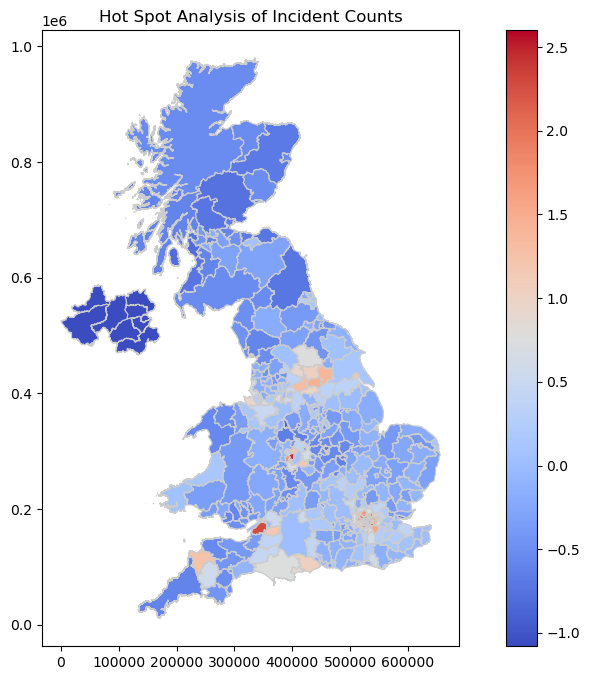

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from esda.getisord import G_Local
from libpysal.weights import Queen

# Create the spatial weights matrix
w = Queen.from_dataframe(merged)

# Calculate Getis-Ord Gi*
g = G_Local(merged['incident_count'], w)
merged['hot_spot'] = g.Zs  # Zs contains the standardized Gi* values

# Plot hot spots
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
merged.plot(column='hot_spot', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_title('Hot Spot Analysis of Incident Counts')
plt.show()


('WARNING: ', 25, ' is an island (no neighbors)')
('WARNING: ', 43, ' is an island (no neighbors)')
('WARNING: ', 49, ' is an island (no neighbors)')
('WARNING: ', 317, ' is an island (no neighbors)')
('WARNING: ', 324, ' is an island (no neighbors)')
('WARNING: ', 330, ' is an island (no neighbors)')
('WARNING: ', 337, ' is an island (no neighbors)')
('WARNING: ', 339, ' is an island (no neighbors)')
('WARNING: ', 353, ' is an island (no neighbors)')
('WARNING: ', 357, ' is an island (no neighbors)')
Geary's C: 0.6477200754383495, p-value: 0.001


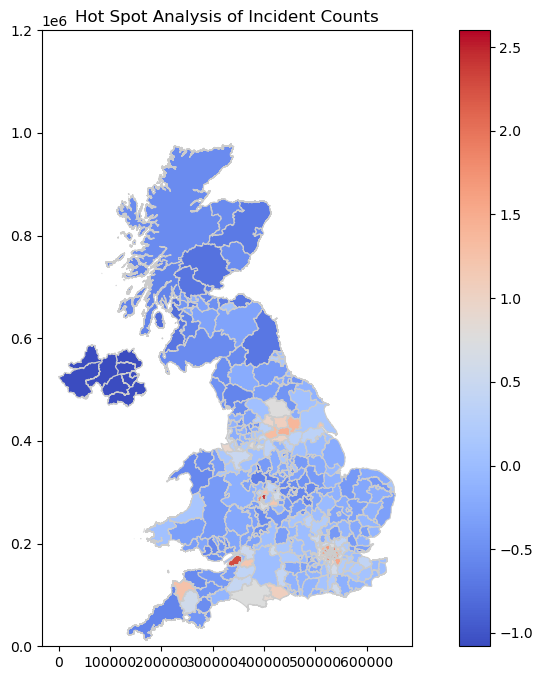

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from esda import Geary, G_Local
from libpysal.weights import Queen

# Create the spatial weights matrix
w = Queen.from_dataframe(merged)

# Calculate Geary's C
geary = Geary(merged['incident_count'], w)
print(f"Geary's C: {geary.C}, p-value: {geary.p_sim}")

# Calculate Getis-Ord Gi*
g_local = G_Local(merged['incident_count'], w)
merged['hot_spot'] = g_local.Zs  # Zs contains the standardized Gi* values

# Plot hot spots
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
merged.plot(column='hot_spot', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Set the y-axis limits
ax.set_ylim(0, 1200000)

ax.set_title('Hot Spot Analysis of Incident Counts')
plt.savefig('fig/hot_spot_analysis_LAD.png')
plt.show()
